In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Lbar for M31 - GADGET

In [3]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength2 as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/SimCLUES/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,50,-1) #SNAPSHOTS

for isnap in snapshot:
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
    
    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#-------------------------------------------------------------------------------------
#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3*aexp[isnap])
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

#---lbar1---------------------------------------------------------------------------------
    phii = phi - phimax
      
    
    for i in range(0,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (-np.arcsin(0.3) - ordenada)/pend
                break

#---lbar 2 ----------------------------------------------------------------------
    mask, = np.where(rbin >= rmax )
    point = A2[mask]
    radio = rbin[mask]
    hbar  = 0.15
    resta = point - hbar

    for kk,_ in enumerate(point):
        if resta[kk] < 0:
            break

    pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
    y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

    lbar2 = (hbar - y0)/ pend
    
#     print 'lbar1 =', lbar1, 'lbar2=', lbar2
# # --------------------------------------------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/M31_lbarvstime.dat','a')
    archivo1.write(str('%12.6f'% time) +'\t'+
             str('%12.6f'% lbar1) +'\t'+
             str('%12.6f'% lbar2) +'\n')
    archivo1.close()
    

### Lbar for MW - GADGET

In [9]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength2 as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/SimCLUES/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,50,-1) #SNAPSHOTS

for isnap in snapshot:
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_001/Center'].value
    r200 = snap['subhalo_001/R200'].value
    
    pstr = snap['subhalo_001/Str/Coordinates'].value
    mstr = snap['subhalo_001/Str/Masses'].value
    vel  = snap['subhalo_001/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
    
    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#-------------------------------------------------------------------------------------
#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3*aexp[isnap])
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

#---lbar1---------------------------------------------------------------------------------
    phii = phi - phimax

    for i in range(0,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (-np.arcsin(0.3) - ordenada)/pend
                break

#---lbar 2 ----------------------------------------------------------------------
    mask, = np.where(rbin >= rmax )
    point = A2[mask]
    radio = rbin[mask]
    hbar  = 0.15
    resta = point - hbar

    for kk,_ in enumerate(point):
        if resta[kk] < 0:
            break

    pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
    y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

    lbar2 = (hbar - y0)/ pend
    
#--------------------------------------------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/MW_lbarvstime.dat','a')
    archivo1.write(str('%12.6f'% time) +'\t'+
             str('%12.6f'% lbar1) +'\t'+
             str('%12.6f'% lbar2) +'\n')
    archivo1.close()

### Lbar for M31 - GASOLINE

In [10]:
import h5py
import rotation as rot
import barstrength2 as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

snapshot = np.loadtxt('/home/ornela/SimCLUES/Gasoline/snapshots.txt', dtype='string') #SNAPSHOTS
snapshot = snapshot[::-1]

for j in range(0,len(snapshot)-1):
    
    snap = h5py.File('/home/ornela/SimCLUES/Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    cm   = snap['subhalo_001/Center'].value
    r200 = snap['subhalo_001/R200'].value
    time = snap['subhalo_001/Time'].value
    h    = snap['subhalo_001/h'].value
    aexp = snap['subhalo_001/aexp'].value
    
    pstr = snap['subhalo_001/Str/Coordinates'].value
    mstr = snap['subhalo_001/Str/Masses'].value
    vel  = snap['subhalo_001/Str/Velocities'].value

#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
#----------------------------------------------------------------------
    
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    corte1, = np.where(r<3*aexp)
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

#---lbar1---------------------------------------------------------------------------------
    phii = phi - phimax

    for i in range(0,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (-np.arcsin(0.3) - ordenada)/pend
                break

#---lbar 2 ----------------------------------------------------------------------
    mask, = np.where(rbin >= rmax )
    point = A2[mask]
    radio = rbin[mask]
    hbar  = 0.15
    resta = point - hbar

    for kk,_ in enumerate(point):
        if resta[kk] < 0:
            break

    pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
    y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

    lbar2 = (hbar - y0)/ pend
    
#--------------------------------------------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/M31_lbarvstime.dat','a')
    archivo1.write(str('%12.6f'% time) +'\t'+
             str('%12.6f'% lbar1) +'\t'+
             str('%12.6f'% lbar2) +'\n')
    archivo1.close()

### Lbar for MW - GASOLINE

In [11]:
import h5py
import rotation as rot
import barstrength2 as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

snapshot = np.loadtxt('/home/ornela/SimCLUES/Gasoline/snapshots.txt', dtype='string') #SNAPSHOTS
snapshot = snapshot[::-1]

for j in range(0,len(snapshot)-1):
    
    snap = h5py.File('/home/ornela/SimCLUES/Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    cm   = snap['subhalo_002/Center'].value
    r200 = snap['subhalo_002/R200'].value
    time = snap['subhalo_002/Time'].value
    h    = snap['subhalo_002/h'].value
    aexp = snap['subhalo_002/aexp'].value
    
    pstr = snap['subhalo_002/Str/Coordinates'].value
    mstr = snap['subhalo_002/Str/Masses'].value
    vel  = snap['subhalo_002/Str/Velocities'].value

#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
#----------------------------------------------------------------------
    
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    corte1, = np.where(r<3*aexp)
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

#---lbar1---------------------------------------------------------------------------------
    phii = phi - phimax

    for i in range(0,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar1 = (-np.arcsin(0.3) - ordenada)/pend
                break

#---lbar 2 ----------------------------------------------------------------------
    mask, = np.where(rbin >= rmax )
    point = A2[mask]
    radio = rbin[mask]
    hbar  = 0.15
    resta = point - hbar

    for kk,_ in enumerate(point):
        if resta[kk] < 0:
            break

    pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
    y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

    lbar2 = (hbar - y0)/ pend
    
#--------------------------------------------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/MW_lbarvstime.dat','a')
    archivo1.write(str('%12.6f'% time) +'\t'+
             str('%12.6f'% lbar1) +'\t'+
             str('%12.6f'% lbar2) +'\n')
    archivo1.close()

In [3]:
# path = '/home/ornela/PYTHON/'
path = '/home/omarioni/'

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime.dat')
time_M31gd  = M31_gd[:,0]
# lbar1_M31gd = M31_gd[:,1]
lbar2_M31gd = M31_gd[:,2]

#------------------------------------------------------------------------------------------

# MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_lbarvstime.dat')
# time_MWgd  = MW_gd[:,0]
# # lbar1_MWgd = MW_gd[:,1]
# lbar2_MWgd = MW_gd[:,2]

#------------------------------------------------------------------------------------------

M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime.dat')
time_M31gs  = M31_gs[:,0]
# lbar1_M31gs = M31_gs[:,1]
lbar2_M31gs = M31_gs[:,2]

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime.dat')
time_MWgs  = MW_gs[:,0]
# lbar1_MWgs = MW_gs[:,1]
lbar2_MWgs = MW_gs[:,2]



In [12]:
# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barra_G1/lbar_time.dat')
# time0 = cm[:,1]
# lbar0 = cm[:,2]

# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barraG1_salida/lbar_time2.dat')
# time1 = cm[:,1]
# lbar1 = cm[:,2]

# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barra_G2/lbar_time.dat')
# time0_ = cm[:,1]
# lbar0_ = cm[:,2]

# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barraG2_salida/lbar_time.dat')
# time1_ = cm[:,1]
# lbar1_ = cm[:,2]

In [4]:
# path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd_/barras/'
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'

cm0   = np.loadtxt(path + 'rcorot_phi_time.dat')
time0 = cm0[:,1]
rcor  = cm0[:,2]

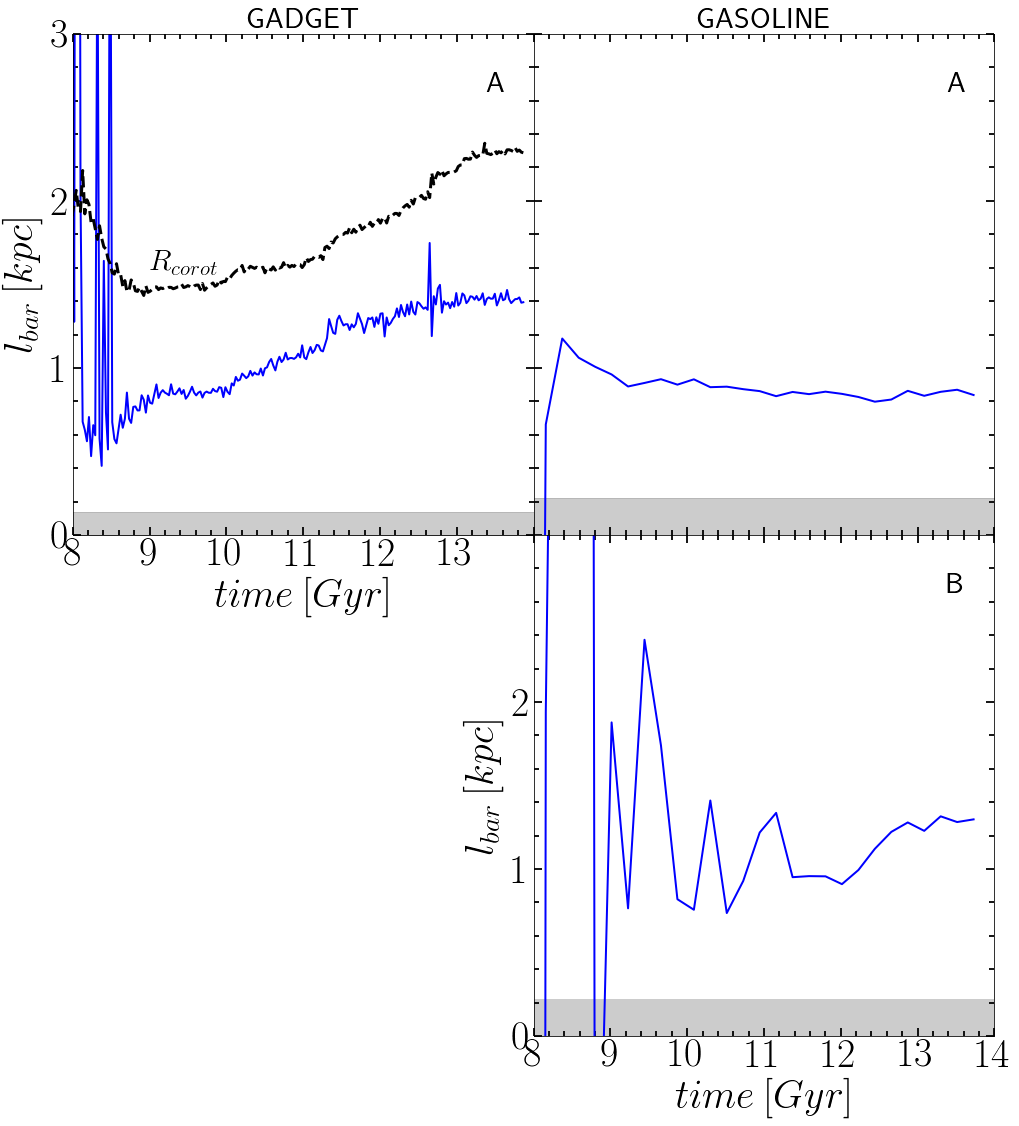

In [21]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))#,sharex=True, sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.9, top = 0.95, wspace=0., hspace= 0)

# lbar1_met, = ax[0,0].plot(time_M31gd ,lbar1_M31gd,'-', lw=2, color='r')
lbar2_met, = ax[0,0].plot(time_M31gd ,lbar2_M31gd,'-', lw=2, color='b')
Rcorot, = ax[0,0].plot(time0 ,rcor,'--', lw=3, color='k')
# ax[0,0].plot(time_M31gd2 ,A2max_M31gd2,'-', lw=3, color='r')
ax[0,0].set_ylabel(r'$l_{bar}\:[kpc]$', fontsize=40)
ax[0,0].set_xticks([8,9,10,11,12,13])
# ax[0,0].set_xticklabels([])
ax[0,0].set_yticks([0,1,2,3])
ax[0,0].set_ylim(0,3)
ax[0,0].set_xlim(8,14)
ax[0,0].set_xlabel(r'$time\:[Gyr]$', fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)
ax[0,0].text(13.5, 2.7, 'A', fontsize=30, color='k', ha='center', va='center')
ax[0,0].text(9, 1.6, r'$R_{corot}$', fontsize=30, color='k', ha='left', va='center')
ax[0,0].fill_between([7,15],0,0.14, facecolor='k', alpha=0.2, color='k') #, hatch='\\'

# ax0 = ax[0,0].twinx()

# # ax[0,0].plot(time_M31gd2 ,A2max_M31gd2,'-', lw=3, color='r')
# # ax0.set_ylabel(r'$A_{2}^{max}$', fontsize=40)
# ax0.set_xticks([8,9,10,11,12,13])
# # ax0.set_xticklabels([])
# ax0.set_yticks([0,1,2,3])
# ax0.set_yticklabels([])
# ax0.set_ylim(0,3)
# ax0.set_xlim(8,14)
# ax0.minorticks_on()
# ax0.tick_params( labelsize=40)
# ax0.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
# ax0.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# # ax0.legend([lbar1_met, lbar2_met, Rcorot],[r'$l_{bar}$ method 1', r'$l_{bar}$ method 2', r'$R_{corot}$'],fontsize=25, frameon=True, loc=2)

#------------------------------------------------------

# ax2=fig.add_subplot(222)
# ax[0,1].plot(time_M31gs ,lbar1_M31gs,'-', lw=2, color='r')
ax[0,1].plot(time_M31gs ,lbar2_M31gs,'-', lw=2, color='b')
# ax[0,1].plot(time_M31gs2 ,A2max_M31gs2,'-',lw=3, color='r')
ax[0,1].set_xticks([8,9,10,11,12,13,14])
ax[0,1].set_xticklabels([])
ax[0,1].set_yticks([0,1,2,3])
ax[0,1].set_yticklabels([])
ax[0,1].set_ylim(0,3)
ax[0,1].set_xlim(8,14)
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)
ax[0,1].text(13.5, 2.7, 'A', fontsize=30, color='k', ha='center', va='center')
ax[0,1].fill_between([7,15],0,0.22, facecolor='k', alpha=0.2, color='k') #, hatch='\\'

# # #---------------------------------------------------------

# ax3=fig.add_subplot(223)
# ax[1,0].plot(time_MWgd ,lbar1_MWgd,'-', lw=2, color='r')
# ax[1,0].plot(time_MWgd ,lbar2_MWgd,'-', lw=2, color='b')
# ax[1,0].plot(time_MWgd2 ,A2max_MWgd2,'-', lw=3, color='r')

# ax[1,0].set_xticks([8,9,10,11,12,13])
# # ax[1,0].set_xticklabels([])
# ax[1,0].set_yticks([0,1,2,3])
# # ax[0,1].set_yticklabels([])
# ax[1,0].set_ylabel(r'$l_{bar}\:[kpc]$', fontsize=40)
# ax[1,0].set_xlabel(r'$time\:[Gyr]$', fontsize=40)
# ax[1,0].set_xlim(8,14)
# ax[1,0].set_ylim(0,4)
# ax[1,0].minorticks_on()
# ax[1,0].tick_params( labelsize=40)
# ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
# ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')



# ax[1,0].text(13.5, 3.7, 'B', fontsize=30, color='k',ha='center', va='center')

ax[1,0].axis('off')


# # #---------------------------------------------------------------------------------------
# # ax4=fig.add_subplot(224)
# ax[1,1].plot(time_MWgs ,lbar1_MWgs,'-', lw=2, color='r')
ax[1,1].plot(time_MWgs ,lbar2_MWgs,'-', lw=2, color='b')
# ax[1,1].plot(time_MWgs2 ,A2max_MWgs2,'-', lw=3, color='r')
ax[1,1].set_xticks([8,9,10,11,12,13,14])
ax[1,1].set_yticks([0,1,2])
# ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time\:[Gyr]$', fontsize=40)
ax[1,1].set_ylabel(r'$l_{bar}\:[kpc]$', fontsize=40)
ax[1,1].set_xlim(8,14)
ax[1,1].set_ylim(0,3)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[1,1].text(13.5, 2.7, 'B', fontsize=30, color='k', ha='center', va='center')
ax[1,1].fill_between([7,15],0,0.22, facecolor='k', alpha=0.2) #, hatch='\\'

# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/lbar_time.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/lbar_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()